In [1]:
import numpy as np
import scipy
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

import geopandas as gpd

matplotlib.rcParams['font.family'] = 'serif'


ERROR 1: PROJ: proj_create_from_database: Open of /home/simon/anaconda3/envs/geo_env_2022/share/proj failed


In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.to_crs(bodies_gdf.crs)
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()

In [3]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities = cities.set_crs(sub_world.crs)
sub_cities_list = list(cities.sjoin(sub_world, how = 'right')['name_left'])[1:]
sub_cities = cities[cities['name'].isin(sub_cities_list)]

In [4]:
def get_ucdp_prio():

    with open(f'/media/simon/Seagate Expansion Drive/Bodies_dfs/PRIO/full_interpl_df_exposure.pkl', 'rb') as file:
        ucdp_prio = pickle.load(file)

    return(ucdp_prio)

ucdp_prio = get_ucdp_prio()

In [5]:
data_dir = '/home/simon/Documents/Bodies/data/done_dfs/'

with open(f'{data_dir}bodies_df_2022_v1_4.pkl', 'rb') as file:
    bodies_df_full = pickle.load(file)

# distance days is distance hours....!!!!!!!!!!!!!!!!!!
bodies_df = bodies_df_full[(bodies_df_full['distance_days'] <= 48) | (bodies_df_full['location_annot'] == 1)].copy() # only locations you are certain of

bodies_df.loc[bodies_df['city'] == 'nan', 'city'] = 'other'

coords = gpd.GeoDataFrame(bodies_df[['longitude_full', 'latitude_full']], geometry=gpd.points_from_xy(bodies_df.longitude_full, bodies_df.latitude_full))
coords = coords.set_crs(sub_world.crs)
#coords = coords.to_crs(sub_world.crs)

bodies_df['coords'] = bodies_df['longitude_full'].astype("string") +'/'+ bodies_df['latitude_full'].astype("string")

In [64]:
def get_coords_gpd( feature, bodies_df = bodies_df, sub_world = sub_world, t = 1):

    sub_df = bodies_df[bodies_df['city'] != 'other']

    if feature == None:
        unique_coords = sub_df.groupby('coords').count()

    else:
        unique_coords = sub_df[sub_df[feature] >= t].groupby('coords').count()
    
    unique_coords = unique_coords['person_mean'].reset_index() # the feature does not matter here
    unique_coords.rename(columns={'person_mean' : 'images'}, inplace= True)

    unique_coords['l_img'] = np.log(unique_coords['images']) # why?

    unique_coords['longitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,0]
    unique_coords['latitude_full'] = unique_coords['coords'].str.split('/', expand = True).loc[:,1]
    unique_coords.drop('coords', axis=1, inplace=True)

    coords = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.longitude_full, unique_coords.latitude_full))
    coords = coords.set_crs(sub_world.crs)

    #city = 'nan' is 33.095579, 44.174977 which is just the centroid of iraq, sp also get rid of those. 
#bodies_df = bodies_df[~(bodies_df['city'] == 'nan')]

    return coords

In [7]:
def city_coord(city):
    x = bodies_df.loc[bodies_df['city'] == city, 'longitude_full'].unique().item()
    y = bodies_df.loc[bodies_df['city'] == city, 'latitude_full'].unique().item()

    return(x,y)

In [46]:
coords = get_coords_gpd(None)
coords_per = get_coords_gpd('person_mean')
coords_fem = get_coords_gpd('female_mean')
coords_gar = get_coords_gpd('religiousGarmentFemale_mean')
coords_uni = get_coords_gpd('uniformed_mean')
coords_fir = get_coords_gpd('firearm_mean')
coords_veh = get_coords_gpd('militaryVehicle_mean')


# Spatial

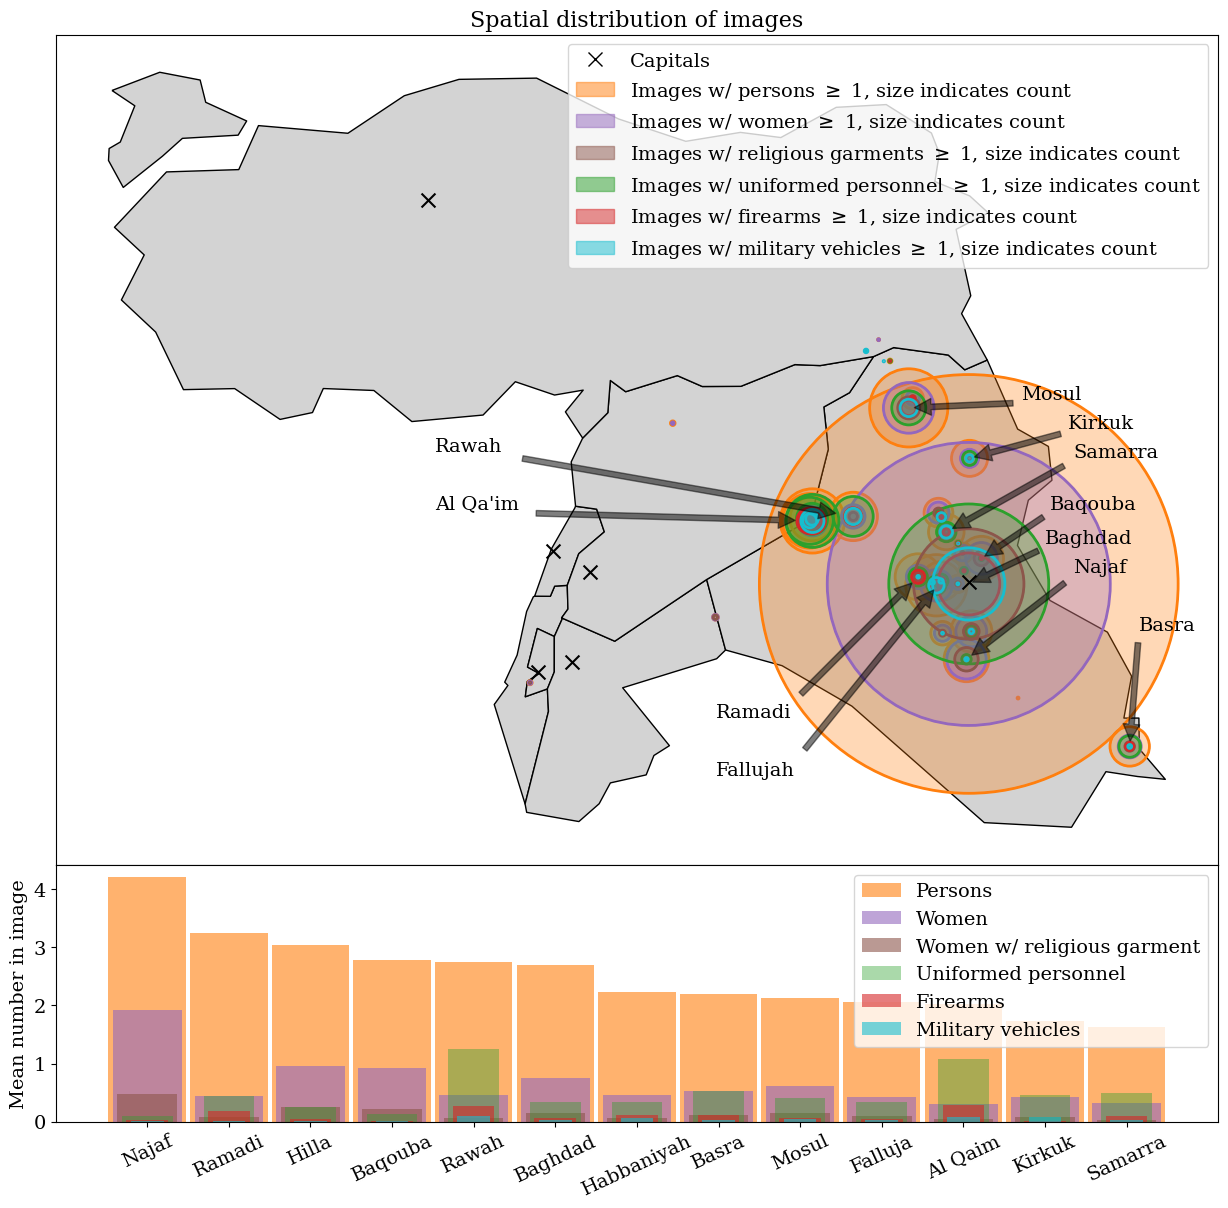

In [182]:
fig, (ax1, ax2) = plt.subplots(2,  figsize=(15, 20), gridspec_kw={'height_ratios': [5, 1]})
fig.subplots_adjust(hspace=0, wspace=0.1)

ax1.set_anchor('SW')
ax2.set_anchor('NW')

ax1.set_title('Spatial distribution of images', fontsize = 16)
#plt.suptitle('Spatial distribution of images', fontsize = 16)


sub_world.plot(ax = ax1,edgecolors = 'black', color = 'lightgray', label = 'Capitals')

#coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], fc = 'none')
#coords.plot(ax=ax, color='C0', marker='o', markersize = coords['images'], alpha = 0.3)

coords_per.plot(ax=ax1, color='C1', marker='o', markersize = coords_per['images'], fc = 'none', linewidths=2)
coords_per.plot(ax=ax1, color='C1', marker='o', markersize = coords_per['images'], alpha = 0.3)

coords_fem.plot(ax=ax1, color='C4', marker='o', markersize = coords_fem['images'], fc = 'none', linewidths=2)
coords_fem.plot(ax=ax1, color='C4', marker='o', markersize = coords_fem['images'], alpha = 0.3)

coords_uni.plot(ax=ax1, color='C2', marker='o', markersize = coords_uni['images'], fc = 'none', linewidths=2)
coords_uni.plot(ax=ax1, color='C2', marker='o', markersize = coords_uni['images'], alpha = 0.3)

coords_gar.plot(ax=ax1, color='C5', marker='o', markersize = coords_gar['images'], fc = 'none', linewidths=2)
coords_gar.plot(ax=ax1, color='C5', marker='o', markersize = coords_gar['images'], alpha = 0.3)

coords_fir.plot(ax=ax1, color='C3', marker='o', markersize = coords_fir['images'], fc = 'none', linewidths=2)
coords_fir.plot(ax=ax1, color='C3', marker='o', markersize = coords_fir['images'], alpha = 0.3)

coords_veh.plot(ax=ax1, color='C9', marker='o', markersize = coords_veh['images'], fc = 'none', linewidths=2)
coords_veh.plot(ax=ax1, color='C9', marker='o', markersize = coords_veh['images'], alpha = 0.3)

sub_cities.plot(ax=ax1, color='black', marker='x', markersize = 100)





# ----------------------------------------------------------------------------------------------
ax1.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(45.5, 36.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Baqouba', xy=(city_coord('Baqouba')), xytext=(46.1, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46, 34), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Abu Ghraib', xy=(city_coord('Abu Ghraib')), xytext=(46.1, 33.8), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Fallujah', xy=(city_coord('Falluja')), xytext=(39, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Al-Karābilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate("Al Qa'im", xy=(city_coord('Husaybah')), xytext=(33, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Samarra', xy=(city_coord('Samarra')), xytext=(46.6, 35.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Najaf', xy=(city_coord('Najaf')), xytext=(46.6, 33.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
# ----------------------------------------------------------------------------------------------

ax1.set_xticks([])
ax1.set_yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

#leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_per = mpatches.Patch(color='C1', label='Images w/ persons $\geq$ 1, size indicates count', alpha = 0.5)
leg_uni = mpatches.Patch(color='C2', label='Images w/ uniformed personnel $\geq$ 1, size indicates count', alpha = 0.5)
leg_fam = mpatches.Patch(color='C4', label='Images w/ women $\geq$ 1, size indicates count', alpha = 0.5)
leg_gar = mpatches.Patch(color='C5', label='Images w/ religious garments $\geq$ 1, size indicates count', alpha = 0.5)
leg_fir = mpatches.Patch(color='C3', label='Images w/ firearms $\geq$ 1, size indicates count', alpha = 0.5)
leg_veh = mpatches.Patch(color='C9', label='Images w/ military vehicles $\geq$ 1, size indicates count', alpha = 0.5)


ax1.legend(handles=[leg_cap, leg_per, leg_fam, leg_gar, leg_uni, leg_fir, leg_veh], fontsize = 14)
# ----------------------------------------------------------------------------------------------

bodies_df['person_dummy'] = (bodies_df['person_mean'] > 0)

person_df = bodies_df[bodies_df['person_mean']>0].copy()

person_df['fem_per_ratio'] = person_df['female_mean'] / person_df['person_mean']
person_df['gar_per_ratio'] =  person_df['religiousGarmentFemale_mean'] / person_df['person_mean']
person_df['uni_per_ratio'] =  person_df['uniformed_mean'] / person_df['person_mean']
person_df['fir_per_ratio'] =  person_df['firearm_mean'] / person_df['person_mean']


person_df.loc[person_df['city'].isin(['Husaybah', 'Karabilah', 'Ar Rabit']), 'city'] = 'Al Qaim'

city_df_count = person_df.groupby('city').count()[['person_mean']]
city_df_count.reset_index(inplace = True)
major_sights = list(city_df_count.loc[city_df_count['person_mean']>500, 'city'])[:-1]

city_df_mean = person_df.groupby('city').mean(numeric_only = True)

city_df_mean.reset_index(inplace = True)
city_df_mean_sub = city_df_mean[city_df_mean['city'].isin(major_sights)][['city', 'militaryVehicle_mean', 'firearm_mean','female_mean', 'person_mean','religiousGarmentFemale_mean','uniformed_mean', 'uni_per_ratio','fem_per_ratio', 'gar_per_ratio']]
city_df_mean_sub.sort_values('person_mean', ascending = False, inplace = True) 

width = np.linspace(0.95,0.4, 6)

ax2.bar(city_df_mean_sub['city'], city_df_mean_sub['person_mean'], color='C1', width = width[0], alpha = 0.6, label = 'Persons')
ax2.bar(city_df_mean_sub['city'], city_df_mean_sub['female_mean'], color='C4', width = width[1], alpha = 0.6, label = 'Women')
ax2.bar(city_df_mean_sub['city'], city_df_mean_sub['religiousGarmentFemale_mean'], color='C5', width = width[2], alpha = 0.6, label = 'Women w/ religious garment')
ax2.bar(city_df_mean_sub['city'], city_df_mean_sub['uniformed_mean'], color='C2', width = width[3], alpha = 0.4, label = 'Uniformed personnel')
ax2.bar(city_df_mean_sub['city'], city_df_mean_sub['firearm_mean'], color='C3', width = width[4], alpha = 0.6, label = 'Firearms')
ax2.bar(city_df_mean_sub['city'], city_df_mean_sub['militaryVehicle_mean'], color='C9', width = width[5], alpha = 0.6, label = 'Military vehicles')


ax2.legend(fontsize = 14)

ax2.tick_params(axis = 'x', labelsize=14, rotation = 25)
ax2.tick_params(axis = 'y', labelsize=14)

ax2.set_yticks(np.arange(0,5,1) )
ax2.set_xticks(city_df_mean_sub['city'])
ax2.set_ylabel('Mean number in image', fontsize = 14)
#ax2.set_xlabel('City', fontsize = 14)


# ----------------------------------------------------------------------------------------------

fig_path = f'/home/simon/Documents/Bodies/figures/frontline/count_motifs.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [70]:
bodies_df['damaged_property_mean'].std()

0.5727838

In [73]:
coords_mil = get_coords_gpd('damaged_property_mean', t = bodies_df['damaged_property_mean'].std())
coords_dam = get_coords_gpd('militarized_mean', t = bodies_df['militarized_mean'].std())
coords_pro = get_coords_gpd('mass_protest_mean', t = bodies_df['mass_protest_mean'].std())

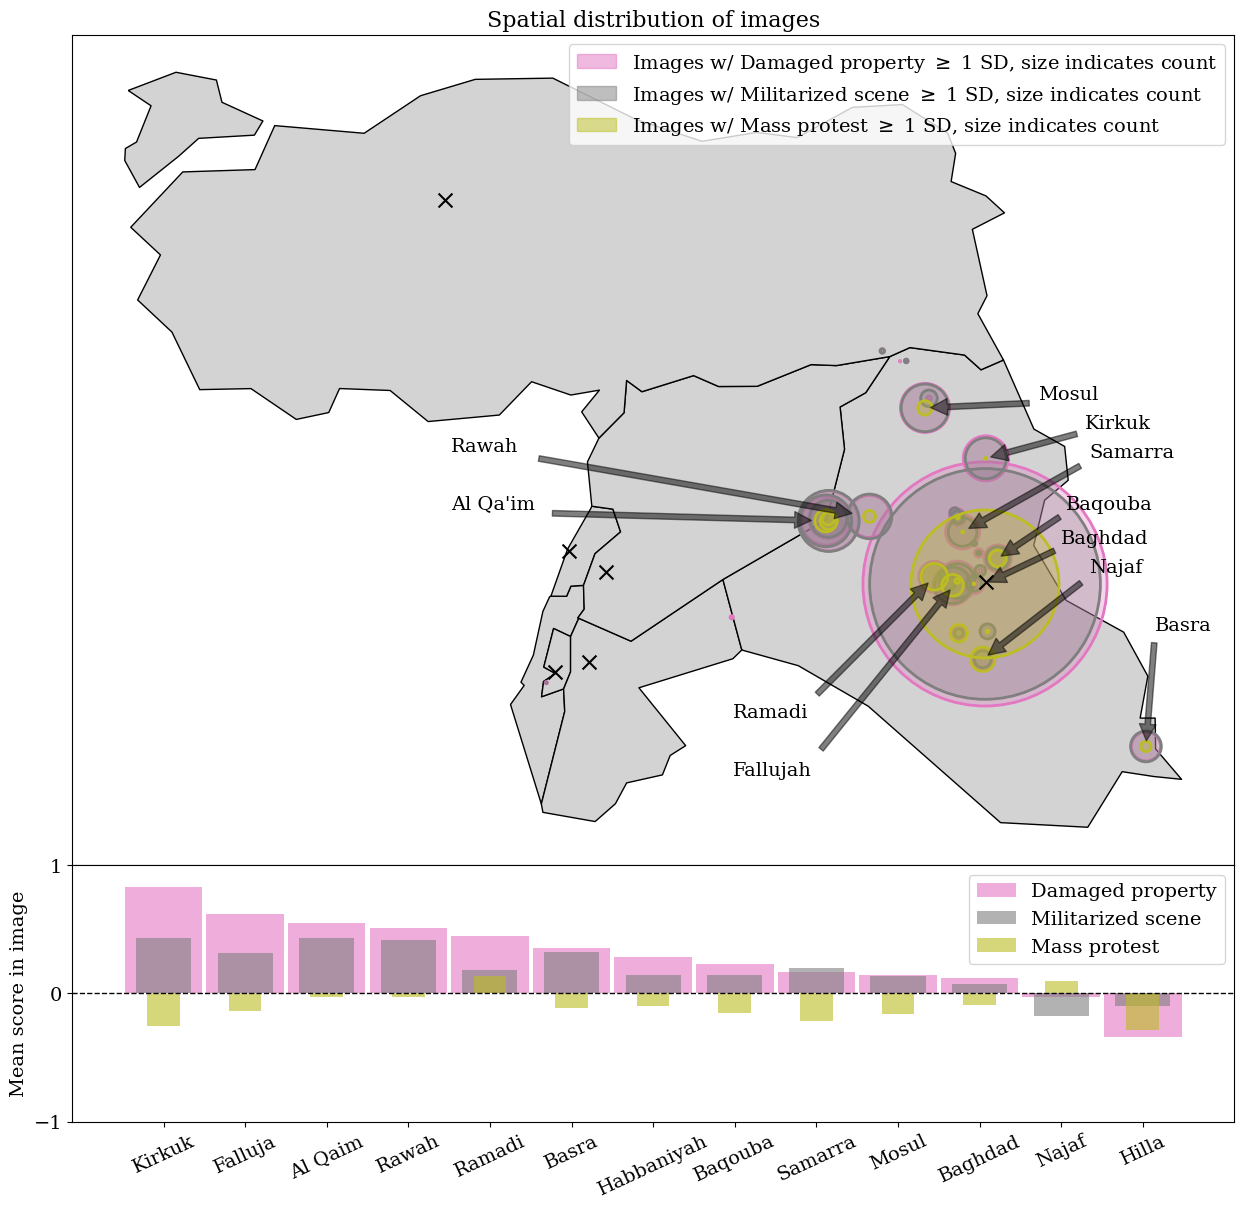

In [74]:
fig, (ax1, ax2) = plt.subplots(2,  figsize=(15, 20), gridspec_kw={'height_ratios': [5, 1]})
fig.subplots_adjust(hspace=0, wspace=0.1)

ax1.set_anchor('SW')
ax2.set_anchor('NW')

ax1.set_title('Spatial distribution of images', fontsize = 16)
#plt.suptitle('Spatial distribution of images', fontsize = 16)


sub_world.plot(ax = ax1,edgecolors = 'black', color = 'lightgray', label = 'Capitals')

coords_mil.plot(ax=ax1, color='C6', marker='o', markersize = coords_mil['images'], fc = 'none', linewidths=2)
coords_mil.plot(ax=ax1, color='C6', marker='o', markersize = coords_mil['images'], alpha = 0.3)

coords_dam.plot(ax=ax1, color='C7', marker='o', markersize = coords_dam['images'], fc = 'none', linewidths=2)
coords_dam.plot(ax=ax1, color='C7', marker='o', markersize = coords_dam['images'], alpha = 0.3)

coords_pro.plot(ax=ax1, color='C8', marker='o', markersize = coords_pro['images'], fc = 'none', linewidths=2)
coords_pro.plot(ax=ax1, color='C8', marker='o', markersize = coords_pro['images'], alpha = 0.3)

sub_cities.plot(ax=ax1, color='black', marker='x', markersize = 100)



# ----------------------------------------------------------------------------------------------
ax1.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(45.5, 36.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Baqouba', xy=(city_coord('Baqouba')), xytext=(46.1, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46, 34), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Abu Ghraib', xy=(city_coord('Abu Ghraib')), xytext=(46.1, 33.8), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Fallujah', xy=(city_coord('Falluja')), xytext=(39, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Al-Karābilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate("Al Qa'im", xy=(city_coord('Husaybah')), xytext=(33, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Samarra', xy=(city_coord('Samarra')), xytext=(46.6, 35.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax1.annotate('Najaf', xy=(city_coord('Najaf')), xytext=(46.6, 33.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
# ----------------------------------------------------------------------------------------------

ax1.set_xticks([])
ax1.set_yticks([])

leg_cap = mlines.Line2D([], [], color='none', markeredgecolor='Black', marker='x', markersize=10, label='Capitals')

#leg_images = mpatches.Patch(color='C0', label='Images, size indicates count', alpha = 0.2)
leg_dam = mpatches.Patch(color='C6', label='Images w/ Damaged property $\geq$ 1 SD, size indicates count', alpha = 0.5)
leg_mil = mpatches.Patch(color='C7', label='Images w/ Militarized scene $\geq$ 1 SD, size indicates count', alpha = 0.5)
leg_mas = mpatches.Patch(color='C8', label='Images w/ Mass protest $\geq$ 1 SD, size indicates count', alpha = 0.5)


ax1.legend(handles=[leg_dam, leg_mil, leg_mas], fontsize = 14)
# ----------------------------------------------------------------------------------------------

bodies_df['person_dummy'] = (bodies_df['person_mean'] > 0)

person_df = bodies_df[bodies_df['person_mean']>0].copy()

person_df.loc[person_df['city'].isin(['Husaybah', 'Karabilah', 'Ar Rabit']), 'city'] = 'Al Qaim'

city_df_count = person_df.groupby('city').count()[['person_mean']]
city_df_count.reset_index(inplace = True)
major_sights = list(city_df_count.loc[city_df_count['person_mean']>500, 'city'])[:-1]

city_df_mean = person_df.groupby('city').mean(numeric_only = True)

city_df_mean.reset_index(inplace = True)
city_df_mean_sub = city_df_mean[city_df_mean['city'].isin(major_sights)][['city', 'person_mean','damaged_property_mean', 'militarized_mean', 'mass_protest_mean']]
city_df_mean_sub.sort_values('damaged_property_mean', ascending = False, inplace = True) 

width = np.linspace(0.95,0.4, 3)

ax2.bar(city_df_mean_sub['city'], city_df_mean_sub['damaged_property_mean'], color='C6', width = width[0], alpha = 0.6, label = 'Damaged property')
ax2.bar(city_df_mean_sub['city'], city_df_mean_sub['militarized_mean'], color='C7', width = width[1], alpha = 0.6, label = 'Militarized scene')
ax2.bar(city_df_mean_sub['city'], city_df_mean_sub['mass_protest_mean'], color='C8', width = width[2], alpha = 0.6, label = 'Mass protest')

ax2.axhline(y=.0, xmin=0, xmax=1, linestyle ='dashed', linewidth=1, color='black')

ax2.legend(fontsize = 14)

ax2.tick_params(axis = 'x', labelsize=14, rotation = 25)
ax2.tick_params(axis = 'y', labelsize=14)

ax2.set_yticks(np.arange(-1,2,1) )
ax2.set_xticks(city_df_mean_sub['city'])
ax2.set_ylabel('Mean score in image', fontsize = 14)
#ax2.set_xlabel('City', fontsize = 14)


# ----------------------------------------------------------------------------------------------

fig_path = f'/home/simon/Documents/Bodies/figures/frontline/score_motifs.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

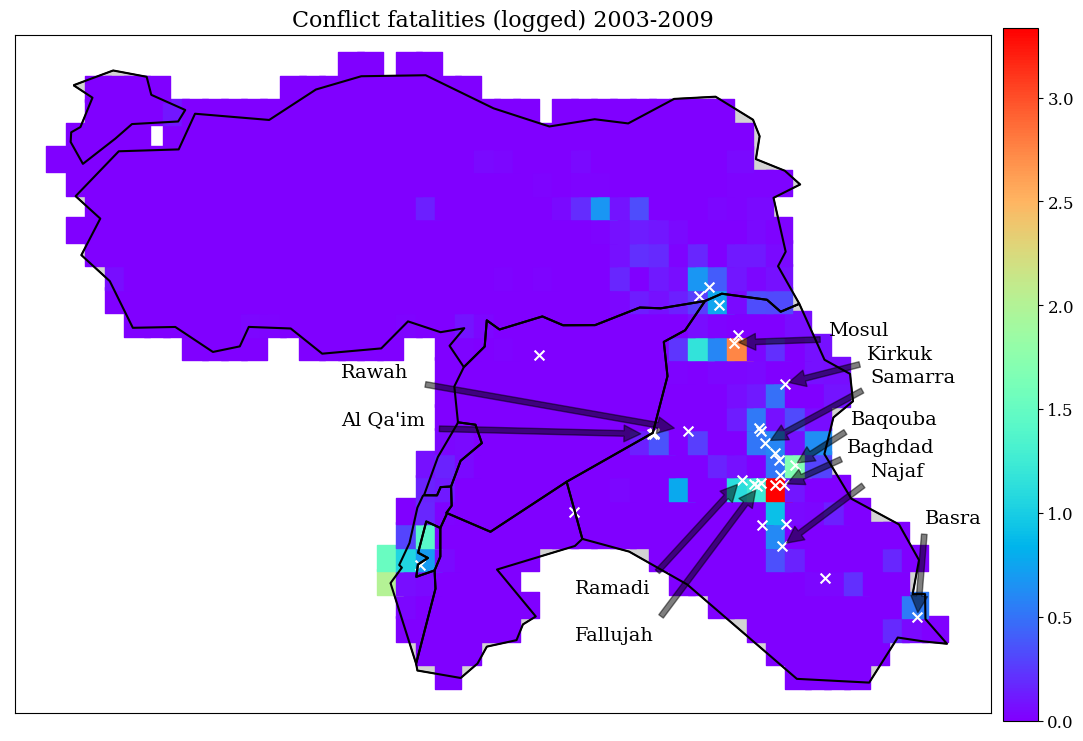

In [76]:
coords_dam = get_coords_gpd('damaged_property_mean')
coords_dam_ratio = pd.merge(coords_dam,coords, on = ['longitude_full', 'latitude_full', 'geometry'], how = 'left')
coords_dam_ratio['ratio'] = coords_dam_ratio['images_x'] / coords_dam_ratio['images_y'] 
# ------------------

years = sorted(bodies_df['year'].unique())[1:]

sub_up = ucdp_prio.loc[ucdp_prio['year'].isin(years) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()


ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 12))
scatter = ax.scatter(sub_up['xcoord'], sub_up['ycoord'], marker = 's', s = 350, c = sub_up['log_best'], cmap = 'rainbow', alpha = 1)
cbar = plt.colorbar(scatter, location = 'right', shrink = 0.75, pad  = 0.01, drawedges = False) # , label= 'log(best+1)'
cbar.ax.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


sub_world.boundary.plot(ax = ax, color = 'black' , figsize=(15, 10))
#sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

#coords_dam_ratio.plot(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, fc = 'none', linewidth=2)
#coords_dam_ratio.(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, alpha = 0.2)


# ----------------------------------------------------------------------------------------------
ax.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(45.5, 36.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baqouba', xy=(city_coord('Baqouba')), xytext=(46.1, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46, 34), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Abu Ghraib', xy=(city_coord('Abu Ghraib')), xytext=(46.1, 33.8), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Fallujah', xy=(city_coord('Falluja')), xytext=(39, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Al-Karābilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate("Al Qa'im", xy=(city_coord('Husaybah')), xytext=(33, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Samarra', xy=(city_coord('Samarra')), xytext=(46.6, 35.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Najaf', xy=(city_coord('Najaf')), xytext=(46.6, 33.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
# ------------------------------------------------------------------------------------------------------------------------------------------------------



plt.title('Conflict fatalities (logged) 2003-2009', fontsize = 16)

plt.xticks([])
plt.yticks([])


coords_per.plot(ax=ax, color='white', marker='x', markersize = 50)

fig_path = f'/home/simon/Documents/Bodies/figures/frontline/fatalies.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [84]:
# indtil det er styr på det her:
bodies_df = bodies_df.loc[bodies_df['publication'] != 'Published']
#bodies_df[['Published', 'Raw', 'Submitted']] = pd.get_dummies(bodies_df[['publication']])
bodies_df[['Raw', 'Submitted']] = pd.get_dummies(bodies_df[['publication']])

In [189]:
monthly_all = bodies_df.groupby('month_id').mean(numeric_only  =True) 
monthly_all.reset_index(inplace= True)
monthly_all = monthly_all[monthly_all['Submitted'] != 1]  # only there are raws

umonth = bodies_df[bodies_df['Raw'].isin([1])]['month_id'].unique() # only there are raws

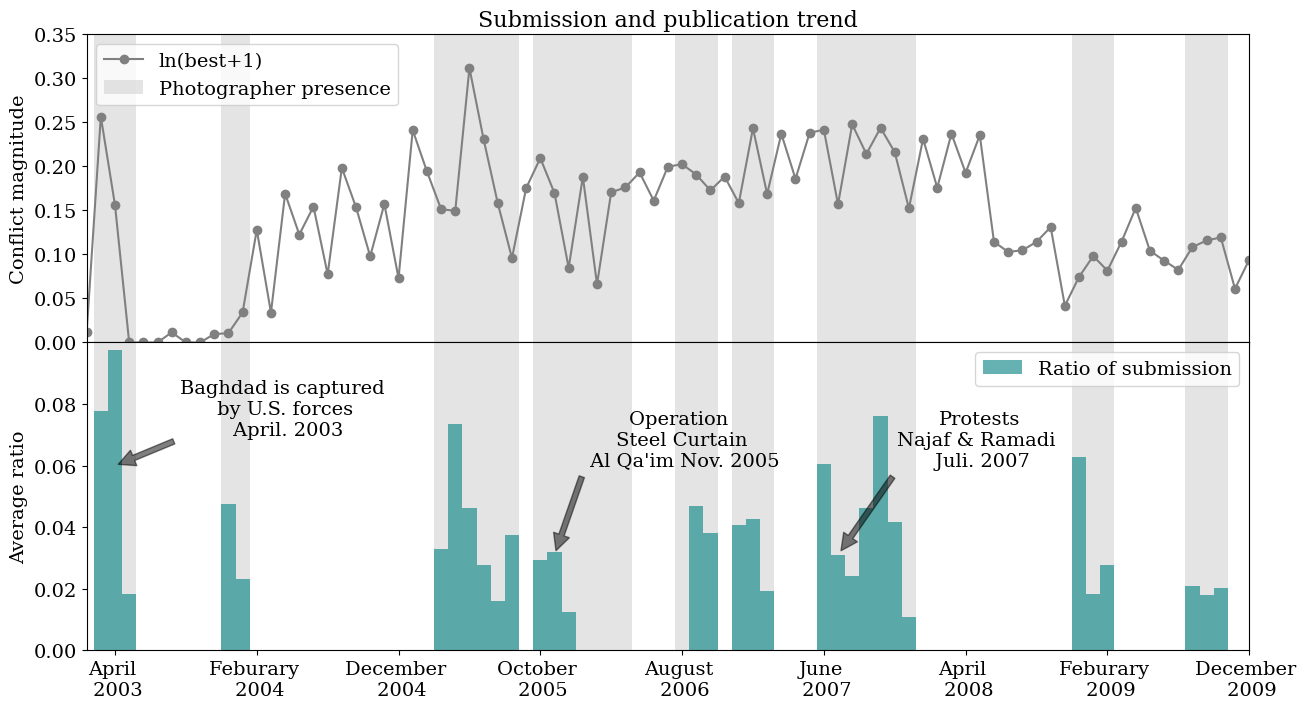

In [192]:
fig, (ax1, ax2) = plt.subplots(2,  figsize=(15, 8), sharex= True, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(hspace=0, wspace=0.1)

ax1.set_anchor('SW')
ax2.set_anchor('NW')

ax1.set_title('Submission and publication trend', fontsize = 16)


# years = sorted(bodies_df['year'].unique())[:]
sub_iraq  = ucdp_prio[(ucdp_prio['gwno'] == 645) & (ucdp_prio['year'] >= 2003)]


x = np.array(list(sub_iraq.groupby('month_id').mean(numeric_only = True).index))
y = sub_iraq.groupby('month_id').mean(numeric_only = True)['log_best'].values

ax1.plot(x,y, '-o', color = 'gray', label = 'ln(best+1)')
#ax1.plot(x,y, '--', color = 'black', label = 'ln(best+1)', alpha = 0.4)

ax1.bar(umonth, 1, width = 1, color = 'lightgray', alpha = 0.6, label = 'Photographer presence')
ax2.bar(umonth, 1, width = 1, color = 'lightgray', alpha = 0.6)



ticks_number = np.arange(280, 370, 10)
ax1.set_xticks(ticks_number, [], fontsize = 14)
ax1.set_xlim(278, 360)
ax1.set_ylim(0,0.35)
ax1.set_ylabel('Conflict magnitude', fontsize = 14)
ax1.legend(fontsize = 14)
ax1.tick_params(axis = 'x', labelsize=14)
ax1.tick_params(axis = 'y', labelsize=14)

ax2.bar(monthly_all['month_id'], monthly_all['Submitted'], width = 1, color = 'teal', alpha = 0.6, label = 'Ratio of submission')

#ax.bar(monthly_per_df['month_id'], monthly_per_df['fem_per_ratio'], width = 0.7, color = 'C4', alpha = 0.6, label = 'Average female/person ratio')

ax2.annotate('Baghdad is captured \n by U.S. forces \n April. 2003', xy=(280, 0.06), xytext=(292, 0.07),
            arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

ax2.annotate("Operation \n Steel Curtain \n Al Qa'im Nov. 2005", xy=(311, 0.031), xytext=(320, 0.06), 
            arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

ax2.annotate('Protests\nNajaf & Ramadi \n Juli. 2007', xy=(331, 0.031), xytext=(341, 0.06), 
            arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')



#plt.xlabel('Month ID', fontsize = 14)
ax2.set_ylabel('Average ratio', fontsize = 14)

ticks_number = np.arange(280, 370, 10)
ticks_name = ['April \n 2003', 'Feburary \n 2004', 'December \n 2004', 'October \n 2005', 'August \n 2006', 'June \n 2007', 'April \n 2008', 'Feburary \n 2009', 'December \n 2009']

ax2.set_xticks(ticks_number, ticks_name, fontsize = 14)
ax2.set_yticks(np.arange(0,0.1,0.02) ,fontsize = 14)
ax2.set_xlim(278, 360)
ax2.set_ylim(0,0.1)
ax2.tick_params(axis = 'x', labelsize=14)
ax2.tick_params(axis = 'y', labelsize=14)


ax2.legend(fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/frontline/publication_trend.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [186]:
bodies_df['month_id'].unique()

array([348, 357, 334, 311, 316, 349, 326, 281, 322, 324, 333, 314, 306,
       315, 312, 307, 303, 331, 304, 356, 308, 313, 330, 321, 288, 358,
       336, 280, 332, 279, 310, 305, 325, 289, 335, 359, 350, 320, 241,
       300, 294, 282, 327, 299])

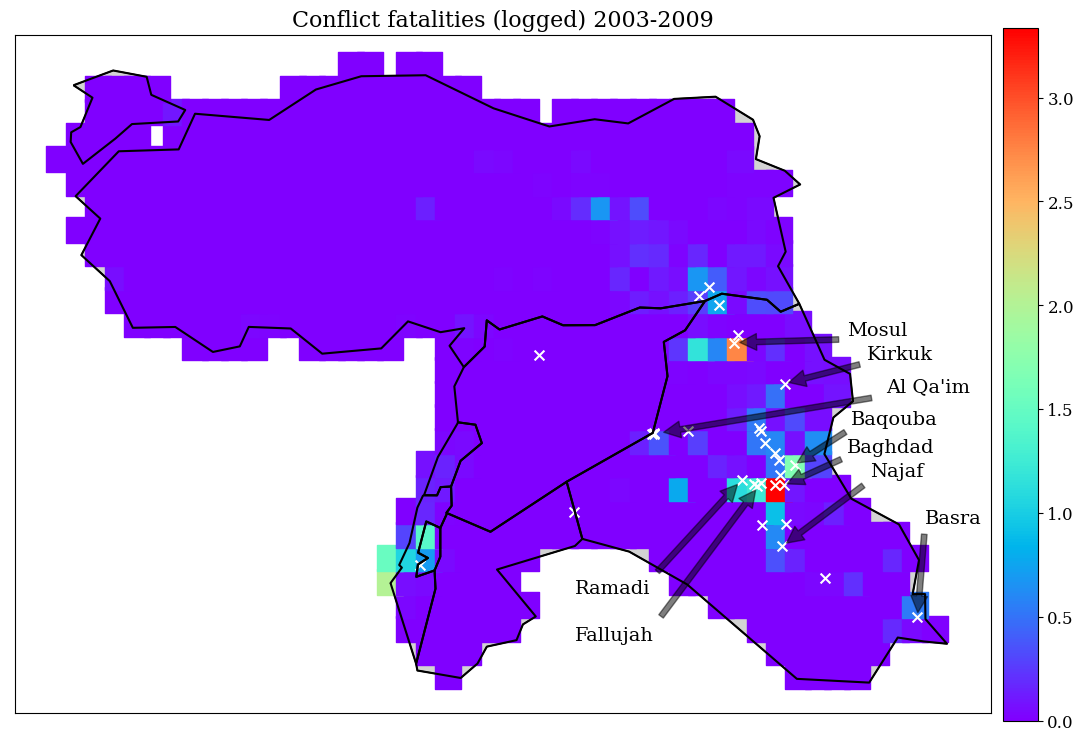

In [10]:
coords_dam = get_coords_gpd('damaged_property_mean')
coords_dam_ratio = pd.merge(coords_dam,coords, on = ['longitude_full', 'latitude_full', 'geometry'], how = 'left')
coords_dam_ratio['ratio'] = coords_dam_ratio['images_x'] / coords_dam_ratio['images_y'] 
# ------------------

years = sorted(bodies_df['year'].unique())[1:]

sub_up = ucdp_prio.loc[ucdp_prio['year'].isin(years) ,['gid', 'log_best', 'tce', 'tsce', 'xcoord','ycoord']].groupby('gid').mean()


ax = sub_world.plot(edgecolors = 'black', color = 'lightgray', figsize=(15, 12))
scatter = ax.scatter(sub_up['xcoord'], sub_up['ycoord'], marker = 's', s = 350, c = sub_up['log_best'], cmap = 'rainbow', alpha = 1)
cbar = plt.colorbar(scatter, location = 'right', shrink = 0.75, pad  = 0.01, drawedges = False) # , label= 'log(best+1)'
cbar.ax.tick_params(labelsize=12)
cbar.ax.tick_params(labelsize=12)


sub_world.boundary.plot(ax = ax, color = 'black' , figsize=(15, 10))
#sub_cities.plot(ax=ax, color='black', marker='x', markersize = 100)

#coords_dam_ratio.plot(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, fc = 'none', linewidth=2)
#coords_dam_ratio.(ax=ax, color='C7', marker='o', markersize = coords_dam_ratio['ratio']* 3000, alpha = 0.2)


# ----------------------------------------------------------------------------------------------
ax.annotate('Basra', xy=(city_coord('Basra')), xytext=(48, 32.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Mosul', xy=(city_coord('Mosul')), xytext=(46, 36.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Kirkuk', xy=(city_coord('Kirkuk')), xytext=(46.5, 36), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baqouba', xy=(city_coord('Baqouba')), xytext=(46.1, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Baghdad', xy=(city_coord('Baghdad')), xytext=(46, 34), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Abu Ghraib', xy=(city_coord('Abu Ghraib')), xytext=(46.1, 33.8), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Fallujah', xy=(city_coord('Falluja')), xytext=(39, 30), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Ramadi', xy=(city_coord('Ramadi')), xytext=(39, 31), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Ar Rabit', xy=(city_coord('Ar Rabit')), xytext=(32, 34.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Al-Karābilah', xy=(city_coord('Karabilah')), xytext=(32, 34.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Husaybah', xy=(city_coord('Husaybah')), xytext=(32, 35.1), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate("Al Qa'im", xy=(city_coord('Husaybah')), xytext=(47, 35.3), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Rawah', xy=(city_coord('Rawah')), xytext=(33, 35.6), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Ad Dawr', xy=(city_coord('Ad Dawr')), xytext=(46.5, 35), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
ax.annotate('Najaf', xy=(city_coord('Najaf')), xytext=(46.6, 33.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
# ----------------------------------------------------------------------------------------------
#ax.annotate('X', xy=(41.8764,36.3208 ), xytext=(36.6, 33.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
#ax.annotate('Najaf', xy=(city_coord('Najaf')), xytext=(46.6, 33.5), arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14)
# ----------------------------------------------------------------------------------------------



plt.title('Conflict fatalities (logged) 2003-2009', fontsize = 16)

plt.xticks([])
plt.yticks([])


coords_per.plot(ax=ax, color='white', marker='x', markersize = 50)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/map4_alt.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [11]:
lats = [32.0010227, 32.4511703, 32.482245]
bodies_df[bodies_df['latitude_full'].isin(lats)]['city'].unique()

array(['Najaf', 'Hilla', 'Kerbala'], dtype=object)

# temporal

In [12]:
bodies_df['person_dummy'] = (bodies_df['person_mean'] > 0)

person_df = bodies_df[bodies_df['person_mean']>0].copy()

person_df['fem_per_ratio'] = person_df['female_mean'] / person_df['person_mean']
person_df['gar_per_ratio'] =  person_df['religiousGarmentFemale_mean'] / person_df['person_mean']

female_df = bodies_df[bodies_df['female_mean']>0].copy()
female_df['gar_fem_ratio'] =  female_df['religiousGarmentFemale_mean'] / female_df['female_mean']

In [13]:
monthly_all = bodies_df.groupby('month_id').mean(numeric_only = True) 
monthly_all = monthly_all.reset_index()

monthly_df = person_df.groupby('month_id').mean(numeric_only = True) 

monthly_per_df = person_df.groupby('month_id').mean(numeric_only = True)
monthly_per_df = monthly_per_df.reset_index()

monthly_fem_df = female_df.groupby('month_id').mean(numeric_only = True)
monthly_fem_df = monthly_fem_df.reset_index()

lwd = [294, 299, 300] # likely wrong dates/months. 
monthly_per_df = monthly_per_df[~monthly_per_df['month_id'].isin(lwd)]
monthly_fem_df = monthly_fem_df[~monthly_fem_df['month_id'].isin(lwd)]
monthly_all = monthly_all[~monthly_all['month_id'].isin(lwd)]

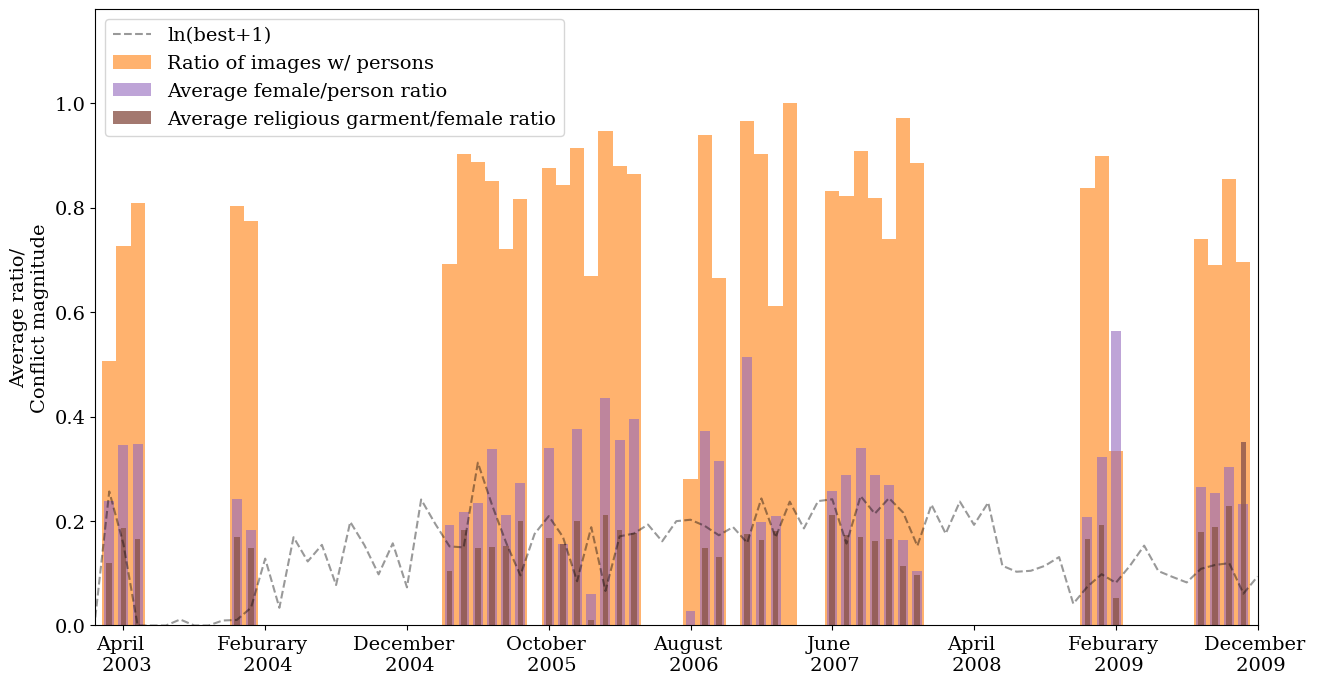

In [14]:
fig, ax = plt.subplots(figsize=[15,8])

ax.bar(monthly_all['month_id'], monthly_all['person_dummy'], width = 1, color = 'C1', alpha = 0.6, label = 'Ratio of images w/ persons')

ax.bar(monthly_per_df['month_id'], monthly_per_df['fem_per_ratio'], width = 0.7, color = 'C4', alpha = 0.6, label = 'Average female/person ratio')

#ax.bar(monthly_per_df['month_id'], monthly_per_df['gar_per_ratio'], width = 0.7, color = 'C5', alpha = 0.6, label = 'Average religious garment/person ratio')

ax.bar(monthly_fem_df['month_id'], monthly_fem_df['gar_fem_ratio'], width = 0.4, color = 'C5', alpha = 0.8, label = 'Average religious garment/female ratio')


years = sorted(bodies_df['year'].unique())[:]
sub_iraq  = ucdp_prio[(ucdp_prio['gwno'] == 645) & ucdp_prio['year'].isin(years)]
x = list(sub_iraq.groupby('month_id').mean(numeric_only = True).index)
plt.plot(x,sub_iraq.groupby('month_id').mean(numeric_only = True)['log_best'].values, '--', color = 'black', label = 'ln(best+1)', alpha = 0.4)


#plt.xlabel('Month ID', fontsize = 14)
plt.ylabel('Average ratio/\nConflict magnitude', fontsize = 14)

ticks_number = np.arange(280, 370, 10)
ticks_name = ['April \n 2003', 'Feburary \n 2004', 'December \n 2004', 'October \n 2005', 'August \n 2006', 'June \n 2007', 'April \n 2008', 'Feburary \n 2009', 'December \n 2009']

plt.xticks(ticks_number, ticks_name, fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(278, 360)
plt.ylim(0,1.18)

plt.legend(fontsize = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/trend3.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()

In [15]:
sub_iraq  = ucdp_prio[(ucdp_prio['gwno'] == 645) & ucdp_prio['year'].isin(years[1:])]

big_city_list = ['Baghdad', 'Mosul', 'Baqouba', 'Ramadi', 'Falluja']
big_city_gid_dict = {}

bodies_df_copy = bodies_df.copy()

#bodies_df_copy.loc[bodies_df_copy['city'].isin(['Husaybah', 'Karabilah', 'Ar Rabit']), 'city'] = 'Al Qaim'

for i in big_city_list:
    big_city_gid_dict[i] = bodies_df_copy[bodies_df_copy['city'] == i]['gid'].unique().item()

# special case
Qaim_list = bodies_df_copy[bodies_df_copy['city'].isin(['Husaybah', 'Karabilah', 'Ar Rabit', 'Al Qaim'])]['gid'].unique()

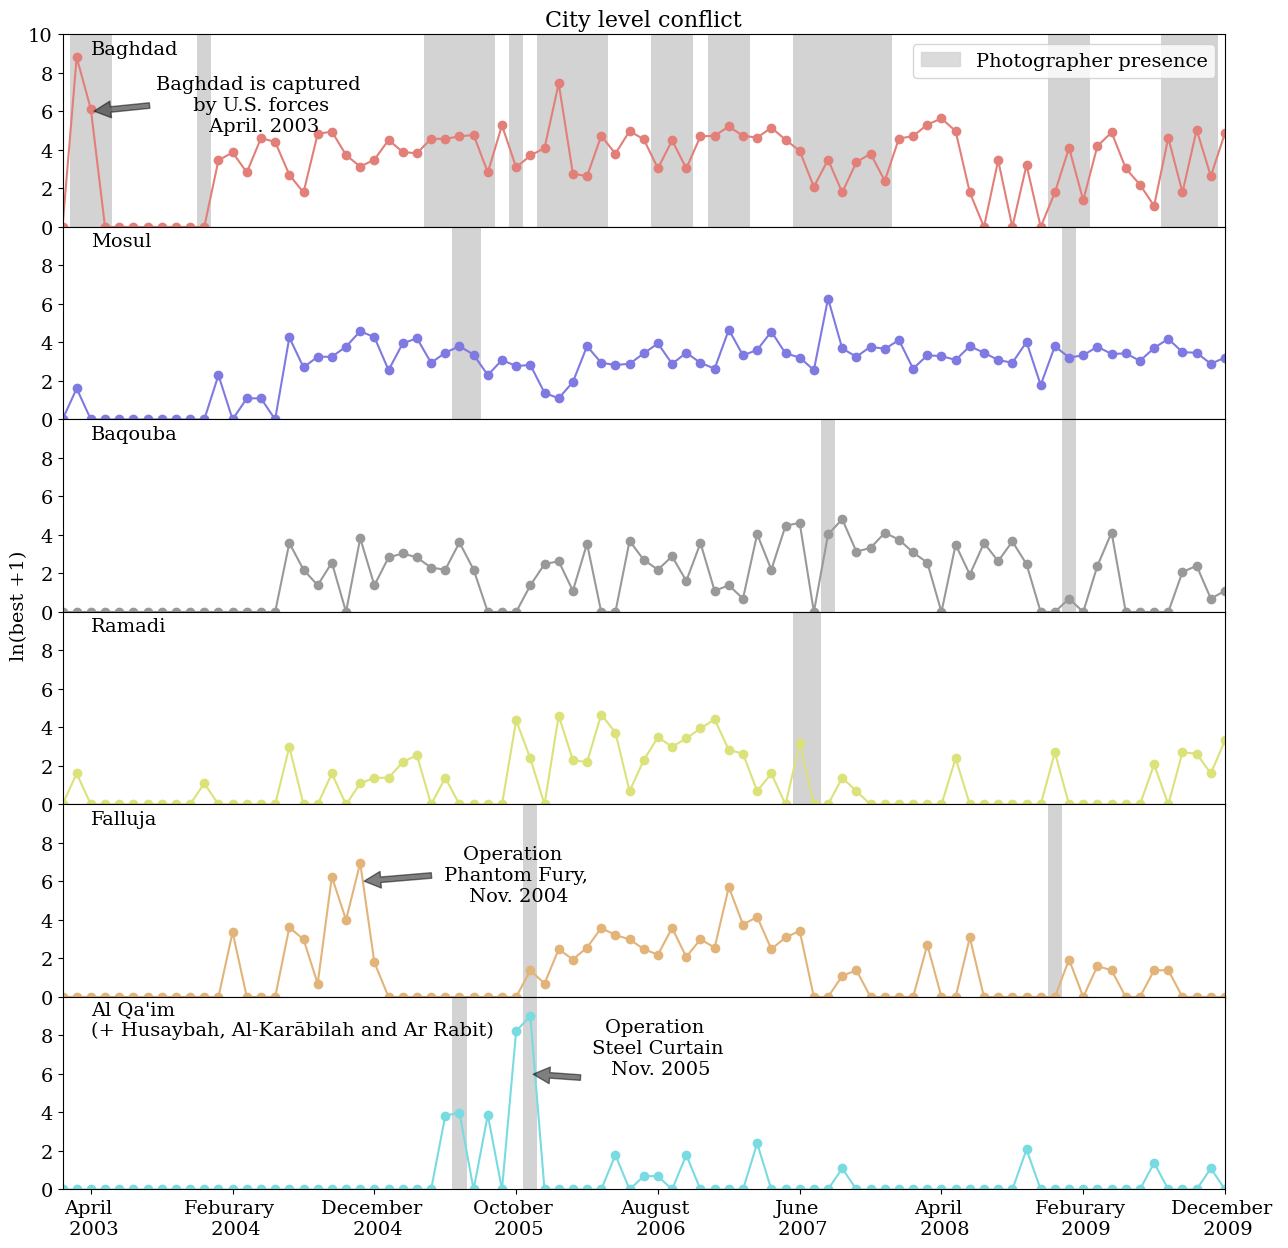

In [16]:
colors = ['#e27f79', '#7f79e2', '#999999', '#dbe279', '#e2b479', '#79dbe2']

fig, axes = plt.subplots(6, figsize = (15,15), sharex= True)
fig.subplots_adjust(hspace=0, wspace=0.1)

Baghdad_df = sub_iraq.loc[sub_iraq['gid'] == big_city_gid_dict['Baghdad'],[ 'month_id',  'log_best']]
Baghdad_df.sort_values('month_id', inplace = True)

Mosul_df = sub_iraq.loc[sub_iraq['gid'] == big_city_gid_dict['Mosul'],[ 'month_id',  'log_best']]
Mosul_df.sort_values('month_id', inplace = True)

Baqouba_df = sub_iraq.loc[sub_iraq['gid'] == big_city_gid_dict['Baqouba'],[ 'month_id',  'log_best']]
Baqouba_df.sort_values('month_id', inplace = True)

Ramadi_df = sub_iraq.loc[sub_iraq['gid'] == big_city_gid_dict['Ramadi'],[ 'month_id',  'log_best']]
Ramadi_df.sort_values('month_id', inplace = True)

Falluja_df = sub_iraq.loc[sub_iraq['gid'] == big_city_gid_dict['Falluja'],[ 'month_id',  'log_best']]
Falluja_df.sort_values('month_id', inplace = True)

Qaim_df = pd.DataFrame(sub_iraq[sub_iraq['gid'].isin(Qaim_list)].groupby('month_id')['log_best'].sum()).reset_index()
big_city_list.append('Al Qaim')

city_df_list = [Baghdad_df, Mosul_df, Baqouba_df, Ramadi_df, Falluja_df, Qaim_df]

for i, df in enumerate(city_df_list):

    if i == 5:
        # axes[i].set_title(f'{big_city_list[i]} (+ Husaybah, Karabilah and Ar Rabit)')
        axes[i].text(280, 8, f"Al Qa'im\n(+ Husaybah, Al-Karābilah and Ar Rabit)", fontsize=14)
        #axes[i].set_xlabel('Month id', fontsize = 14)
        ticks_number = np.arange(280, 370, 10)
        ticks_name = ['April \n 2003', 'Feburary \n 2004', 'December \n 2004', 'October \n 2005', 'August \n 2006', 'June \n 2007', 'April \n 2008', 'Feburary \n 2009', 'December \n 2009']

        axes[i].set_xticks(ticks_number, ticks_name)


    else:
        # axes[i].set_title(big_city_list[i])
        axes[i].text(280, 9, big_city_list[i], fontsize=14)

    axes[i].plot(df['month_id'],df['log_best'], '-o', color = colors[i])
    axes[i].bar(bodies_df.loc[bodies_df['city'] ==  big_city_list[i],'month_id'].unique(), 10, width = 1, color = 'lightgray')
    axes[i].set_ylim(0,10)
    axes[i].set_xlim(278, 360)

    if i == 0:
        axes[i].set_yticks(np.arange(0,12,2))
        axes[i].set_title('City level conflict', fontsize = 16)
        
        leg = mpatches.Patch(color='lightgray', label='Photographer presence', alpha = 0.8)
        axes[i].legend(handles=[leg], loc = 'upper right', fontsize = 14)

    else:
        axes[i].set_yticks(np.arange(0,10,2))

    axes[i].tick_params(axis = 'x', labelsize=14)
    axes[i].tick_params(axis = 'y', labelsize=14)

    if i == 0:
        axes[i].annotate('Baghdad is captured \n by U.S. forces \n April. 2003', xy=(280, 6), xytext=(292, 5),
        arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

    elif i == 4:
        axes[i].annotate('Operation \n Phantom Fury, \n Nov. 2004', xy=(299, 6), xytext=(310, 5),
                     arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')

        # axes[i].annotate('Operation \n Vigilant Resolve, \n April. 2004', xy=(292, 2), xytext=(285, 5),
        #              arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')
 
    elif i == 5:
        axes[i].annotate('Operation \n Steel Curtain \n Nov. 2005', xy=(311, 6), xytext=(320, 6), 
                    arrowprops=dict(facecolor='black', shrink=0.05, alpha = 0.5), fontsize = 14, horizontalalignment='center')





fig.text(0.09, 0.5, 'ln(best +1)', va='center', rotation='vertical', fontsize  = 14)

fig_path = f'/home/simon/Documents/Bodies/figures/maps/introducing/trend_cities.png'
plt.savefig(fig_path, bbox_inches="tight")

plt.show()


In [17]:
bodies_df[bodies_df['city'].isin(['Husaybah', 'Karabilah', 'Ar Rabit', 'Al Qaim'])]['month_id'].unique()

array([311, 306])

In [18]:
bodies_df[(bodies_df['city'].isin(['Husaybah', 'Karabilah', 'Ar Rabit', 'Al Qaim'])) & (bodies_df['month_id'] == 311)]['militarized_mean'].mean()

0.41060254

In [19]:
bodies_df[(bodies_df['city'].isin(['Husaybah', 'Karabilah', 'Ar Rabit', 'Al Qaim'])) & (bodies_df['month_id'] == 306)]['militarized_mean'].mean()

0.39465794

In [20]:
bodies_df['month_id'].unique().shape

(44,)

In [21]:
bodies_df['city'].unique().shape

(33,)

In [22]:
bodies_df['gid'].unique().shape

(24,)